In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import itertools
warnings.filterwarnings("ignore")
import statsmodels.api as sm
import matplotlib

In [4]:
# importing predict-demand data 
data=pd.read_csv("train.csv")

In [5]:
data.head()

,id,date,city,lat,long,pop,shop,brand,container,capacity,price,quantity
0,0.0,31/01/12,Athens,37.97945,23.71622,672130.0,shop_1,kinder-cola,glass,500ml,0.96,13280.0
1,1.0,31/01/12,Athens,37.97945,23.71622,672130.0,shop_1,kinder-cola,plastic,1.5lt,2.86,6727.0
2,2.0,31/01/12,Athens,37.97945,23.71622,672130.0,shop_1,kinder-cola,can,330ml,0.87,9848.0
3,3.0,31/01/12,Athens,37.97945,23.71622,672130.0,shop_1,adult-cola,glass,500ml,1.00,20050.0
4,4.0,31/01/12,Athens,37.97945,23.71622,672130.0,shop_1,adult-cola,can,330ml,0.39,25696.0


In [6]:
# converting column 'date' into pandas date-time format 
data['date'] = pd.to_datetime(data['date'])

### Data Pre-processing

In [7]:
# checking for missing values
data.isna().sum()
# there are missing values

id           1080
date         1080
city         1080
lat          1131
long         1126
pop          1080
shop         1080
brand        1080
container    1096
capacity     1095
price        1080
quantity     1080
dtype: int64

In [8]:
# Removing the rows with missing values
data.dropna(axis=0,inplace=True)

In [9]:
data.isna().sum()

id           0
date         0
city         0
lat          0
long         0
pop          0
shop         0
brand        0
container    0
capacity     0
price        0
quantity     0
dtype: int64

In [10]:
data.shape

(6376, 12)

In [11]:
# Our target is to predict the 'quantity' for each shop category. So removing all other irrelevant columns.
cols=['id', 'city', 'lat', 'long', 'pop', 'brand','container', 'capacity', 'price']
data.drop(cols,axis=1,inplace=True)

In [12]:
# Count of data samples in each shop category
data.groupby('shop')['quantity'].count()

shop
shop_1    1061
shop_2    1061
shop_3    1061
shop_4    1066
shop_5    1062
shop_6    1065
Name: quantity, dtype: int64

In [13]:
# Store shop_1 data seperately to analyze each seperately
shop1_data=data[data['shop']=='shop_1'][['date','quantity']]
shop1_data.head()

,date,quantity
0,2012-01-31,13280.0
1,2012-01-31,6727.0
2,2012-01-31,9848.0
3,2012-01-31,20050.0
4,2012-01-31,25696.0


In [14]:
# Similarly storing each shop data seperately
shop2_data=data[data['shop']=='shop_2'][['date','quantity']]
shop3_data=data[data['shop']=='shop_3'][['date','quantity']]
shop4_data=data[data['shop']=='shop_4'][['date','quantity']]
shop5_data=data[data['shop']=='shop_5'][['date','quantity']]
shop6_data=data[data['shop']=='shop_6'][['date','quantity']]

### Analysis and Visualization on Time Series Data

In [15]:
# Resampling these data on month-wise basis
y1=shop1_data.resample('M',on='date').sum()
y2=shop2_data.resample('M',on='date').sum()
y3=shop3_data.resample('M',on='date').sum()
y4=shop4_data.resample('M',on='date').sum()
y5=shop5_data.resample('M',on='date').sum()
y6=shop6_data.resample('M',on='date').sum()

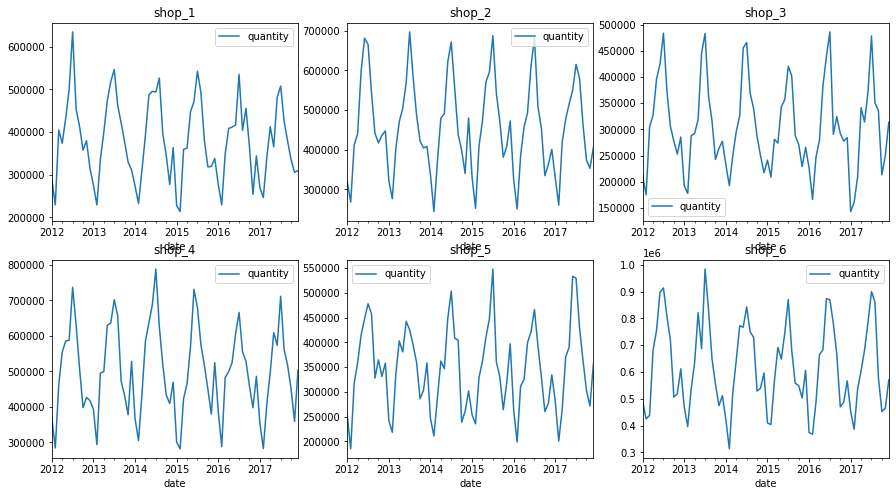

In [16]:
# Ploting quantity Vs date
col_list = [y1,y2,y3,y4,y5,y6]
titl=['shop_1','shop_2','shop_3','shop_4','shop_5','shop_6']
nrow=2
ncol=3
fig, axes = plt.subplots(nrow, ncol)
# plot counter
count=0
for r in range(nrow):
    for c in range(ncol):
        col_list[count].plot(ax=axes[r,c],figsize=(15,8),title=titl[count])
        count+=1
plt.show()
# We can observe in each figure, quantity varible's variation with date-time shows a similar repeating pattern.

In [17]:
# Analyse the different conmponents of time-series data - seasonal,trend,residual 
from statsmodels.tsa.seasonal import seasonal_decompose

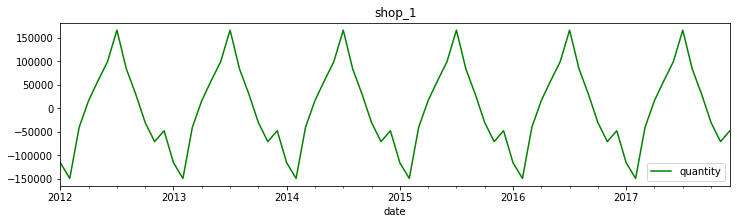

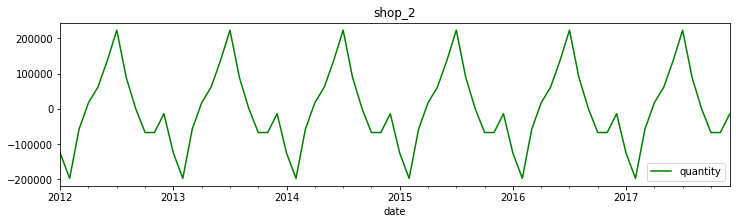

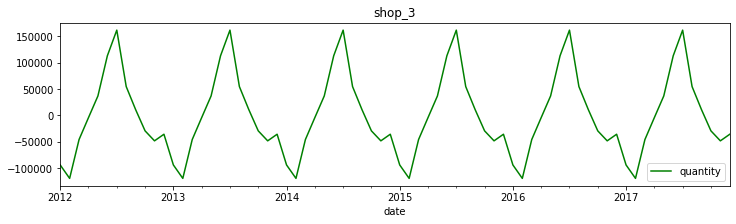

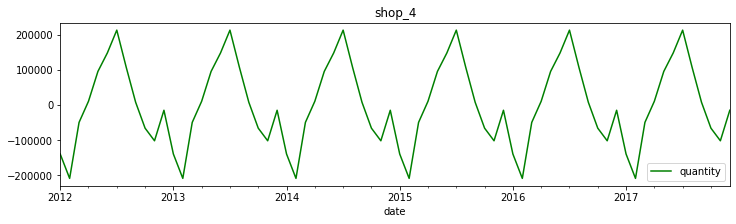

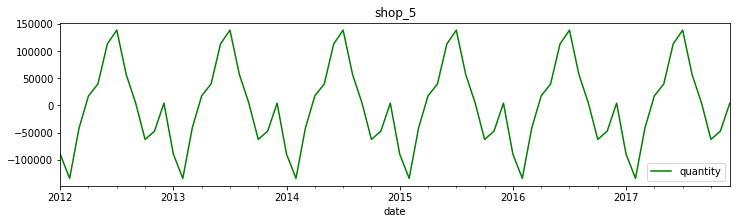

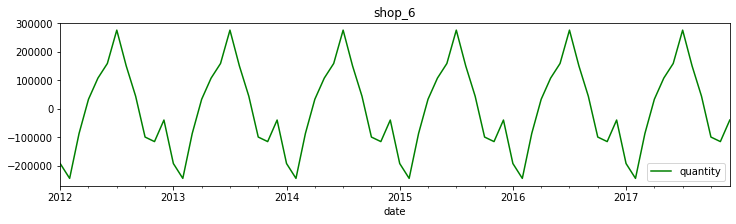

In [18]:
# Seasonality
for count in range(6):
  decompose_data= seasonal_decompose(col_list[count], model="additive") 
  seasonality=decompose_data.seasonal
  seasonality.plot(figsize=(12,3),color='green',title=titl[count])
  plt.show()
  # This figures clearly show there is seasonality in the data of each shop and those are very similar

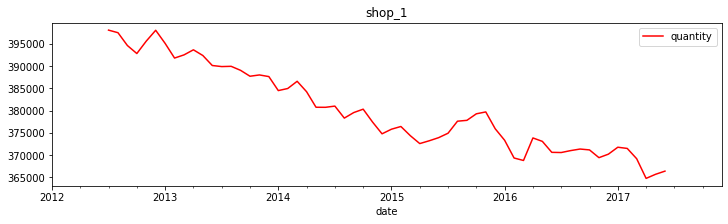

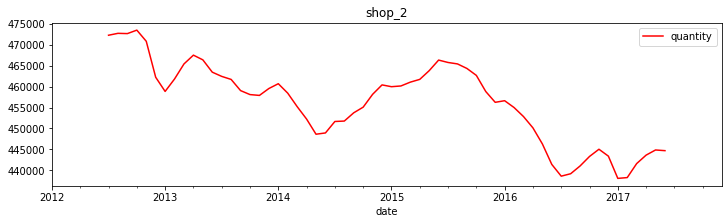

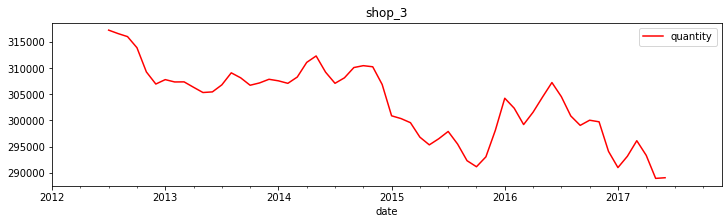

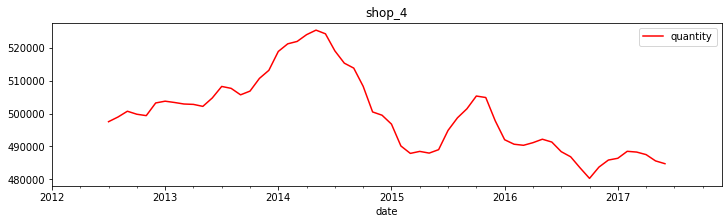

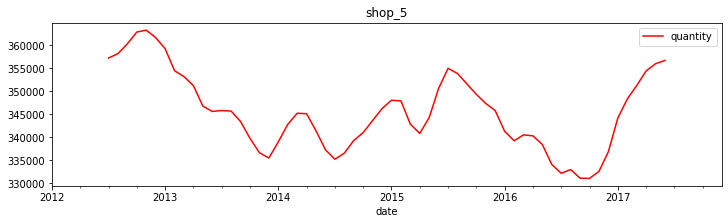

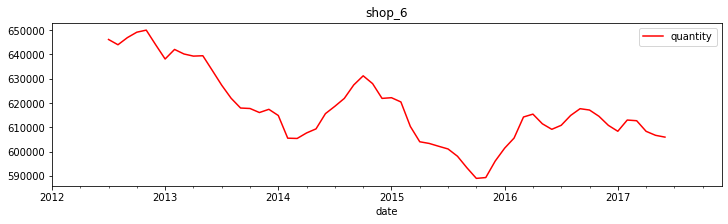

In [19]:
# Trend
trend_=decompose_data.trend
for count in range(6):
  decompose_data= seasonal_decompose(col_list[count], model="additive") 
  trend_=decompose_data.trend
  trend_.plot(figsize=(12,3),color='red',title=titl[count])
  plt.show()
# trend in each shop category data are different from one another.   

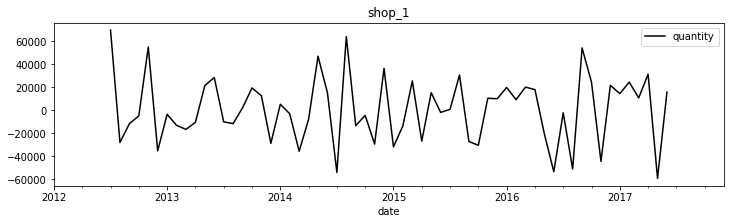

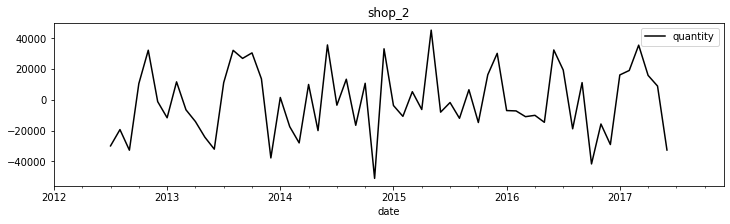

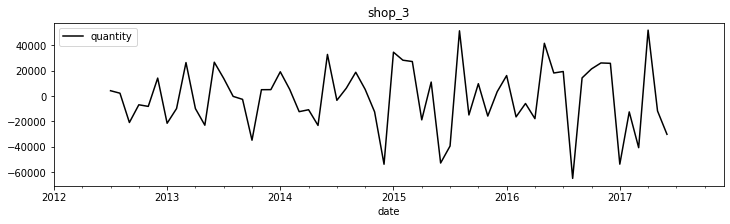

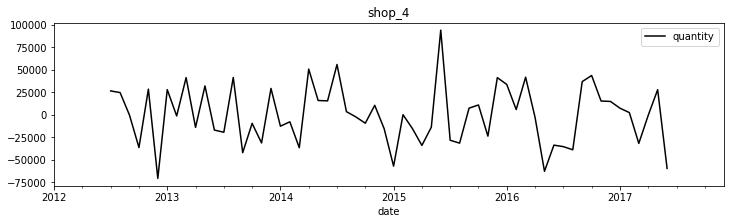

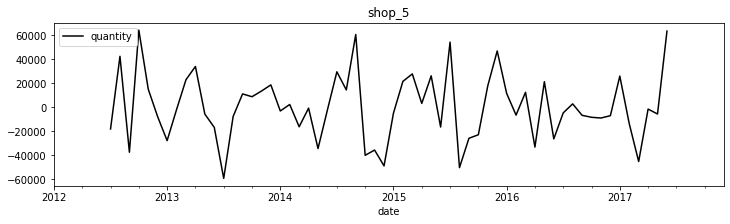

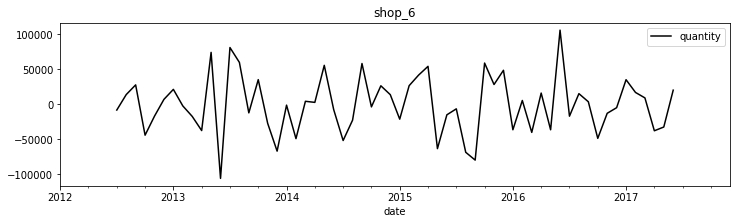

In [20]:
# Residual
for count in range(6):
  decompose_data= seasonal_decompose(col_list[count], model="additive") 
  res_=decompose_data.resid
  res_.plot(figsize=(12,3),color='black',title=titl[count])
  plt.show()
  

In [21]:
# From these visualizations we can observe that our data shows high variations with time. 
# This indicates the non-stationarity nature of data. For getting more understanding on the stationarity of data,
# we can perform the ADfuller test, which is hypothesis test. 

In [22]:
from statsmodels.tsa.stattools import adfuller
for count in range(6):
  dftest = adfuller(col_list[count].quantity, autolag = 'AIC')
  print("Shop Category : ",titl[count].upper())
  print("---------------------------")
  print("1. ADF : ",dftest[0])
  print("2. P-Value : ", dftest[1])
  print("3. Num Of Lags : ", dftest[2])
  print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
  print("5. Critical Values :")
  for key, val in dftest[4].items():
    print("\t",key, ": ", val,"\n")

Shop Category :  SHOP_1
---------------------------
1. ADF :  -1.390056293063451
2. P-Value :  0.587033863536096
3. Num Of Lags :  12
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 59
5. Critical Values :
	 1% :  -3.5463945337644063 

	 5% :  -2.911939409384601 

	 10% :  -2.5936515282964665 

Shop Category :  SHOP_2
---------------------------
1. ADF :  -1.63573134249765
2. P-Value :  0.46449214976354813
3. Num Of Lags :  11
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 60
5. Critical Values :
	 1% :  -3.5443688564814813 

	 5% :  -2.9110731481481484 

	 10% :  -2.5931902777777776 

Shop Category :  SHOP_3
---------------------------
1. ADF :  -2.1030539525313414
2. P-Value :  0.24328836641936263
3. Num Of Lags :  11
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 60
5. Critical Values :
	 1% :  -3.5443688564814813 

	 5% :  -2.9110731481481484 

	 10% :  -2.5931902777777776 

Shop Ca

In [23]:
# For a data to be a stationary, p-value should be less than 0.05. Here in each case, p-value is higher than 0.05. Hence
# the data is non-stationary. To perform forecasting with ARIMA model, the data should be stationary. Here, as our data
# shows Seasonality and Non-stationary nature, we can go for SARIMAX model which includes seasonal effects and eXogenous
# factors with the autoregressive and moving average component in the model. 

### Time Series Forecasting using SARIMAX Model

In [24]:
# Resampling the data by combining day-wise samples 
d1=shop1_data.resample('D',on='date').sum()
d2=shop2_data.resample('D',on='date').sum()
d3=shop3_data.resample('D',on='date').sum()
d4=shop4_data.resample('D',on='date').sum()
d5=shop5_data.resample('D',on='date').sum()
d6=shop6_data.resample('D',on='date').sum()

## Shop_1 Predictions

In [25]:
warnings.filterwarnings("ignore")

In [26]:
d1=shop1_data.set_index('date').resample('D').sum()
d1=d1[d1['quantity']>0]
# Considering only non-zero values

In [27]:
# Spliting of data into training and testing sets
training_data=d1[:60]
testing_data=d1[60:]

In [28]:
# function to find the best combination of parameters for the model
def best_parameters(y):
    
    # Parameters for ARIMA model
    p=d=q=range(0, 2)
    
    # Creating all posssible combinations of Seasonal ARIMA
    pdq=list(itertools.product(p,d,q))
    seasonal_pdq=[(x[0],x[1],x[2],12) for x in list(itertools.product(p, d, q))]
    minAIC=100000000
    b_pdq=(0,0,0)
    b_spdq=(0,0,0)
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(y,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
                results = mod.fit()
                # Finding minimum value of AIC and Parameters corresponding minimum AIC value
                if results.aic<minAIC:
                    minAIC=results.aic
                    #print(results.aic)
                    b_pdq=param
                    b_spdq=param_seasonal
            except:
                continue
                
    print("best parameters: ",b_pdq)
    print("best seasonal parameters :",b_spdq)
    print("minimum aic value",minAIC)
    return b_pdq,b_spdq

In [29]:
best_p,best_sp = best_parameters(training_data)

best parameters:  (1, 1, 1)
best seasonal parameters : (1, 1, 0, 12)
minimum aic value 826.9159535684698


In [30]:
# Creating ARIMA model 
model=sm.tsa.statespace.SARIMAX(training_data,order=best_p,seasonal_order=best_sp,enforce_stationarity=False,enforce_invertibility=False)
ts_model=model.fit()

In [31]:
#Forecasting data for next one year
testing_data['predicted'] = ts_model.forecast(steps=12)

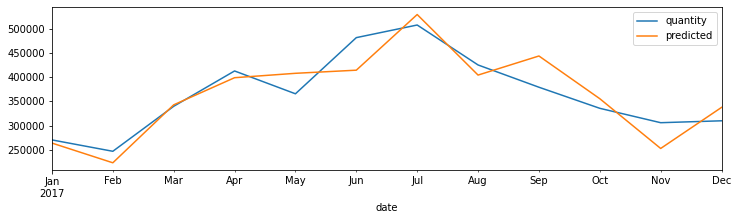

In [32]:
testing_data[['quantity','predicted']].plot(figsize=(12,3))

In [33]:
pred=testing_data['predicted']
actual=testing_data['quantity']

In [34]:
# Root Mean Square Calculation
def rmse_calc(pred,actual):
    mse = ((pred - actual) ** 2).mean()
    rmse=np.sqrt(mse)
    print("RMSE : ",rmse)
    return rmse

In [35]:
rmse_val=rmse_calc(pred,actual)

RMSE :  36735.518120690605


### Evaluating the Model using Nested Cross Validation

In [36]:
training_data=d1[:60]
testing_data=d1[60:]

In [37]:
train_data=training_data['quantity']

In [38]:
from cv import *

ERROR:root:Error disabling cv.imshow().
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/google/colab/_import_hooks/_cv2.py", line 86, in load_module
    cv_module.imshow,
AttributeError: module 'cv' has no attribute 'imshow'


In [39]:
def nested_cv(train_data,k):
  ncv = NestedCV(k)
  splits = ncv.split(train_data,"date")
  warnings.filterwarnings("ignore")
  count=0
  RMSE_history={}
  Best_Params={}
  for train,validate in splits:
    print("NO OF ITERATION:",count+1)
    best_param,best_seasonal = best_parameters(train)        # Hyper parameter tuning
    model=sm.tsa.statespace.SARIMAX(train,order=best_param,seasonal_order=best_seasonal,enforce_stationarity=False,enforce_invertibility=False)
    SARIMAX_model=model.fit()
    forecast = SARIMAX_model.forecast()
    RMSE_history[count+1]=rmse_calc(forecast,validate.values)
    Best_Params[count+1]=best_param,best_seasonal
    count+=1
  return RMSE_history,Best_Params

In [40]:
k = len(train_data)-1

In [41]:
RMSE_history,Best_Params=nested_cv(train_data,k)

NO OF ITERATION: 1
best parameters:  (0, 0, 0)
best seasonal parameters : (0, 0, 0, 12)
minimum aic value 2.0
RMSE :  229722.0
NO OF ITERATION: 2
best parameters:  (1, 0, 0)
best seasonal parameters : (0, 0, 0, 12)
minimum aic value -17.187973863531113
RMSE :  222162.40281168098
NO OF ITERATION: 3
best parameters:  (1, 1, 0)
best seasonal parameters : (0, 0, 0, 12)
minimum aic value -17.187973863531113
RMSE :  483505.4522521008
NO OF ITERATION: 4
best parameters:  (0, 0, 0)
best seasonal parameters : (0, 1, 0, 12)
minimum aic value 2.0
RMSE :  431795.0
NO OF ITERATION: 5
best parameters:  (0, 0, 0)
best seasonal parameters : (0, 1, 0, 12)
minimum aic value 2.0
RMSE :  500770.0
NO OF ITERATION: 6
best parameters:  (0, 0, 0)
best seasonal parameters : (0, 1, 0, 12)
minimum aic value 2.0
RMSE :  634466.0
NO OF ITERATION: 7
best parameters:  (0, 0, 0)
best seasonal parameters : (0, 1, 0, 12)
minimum aic value 2.0
RMSE :  453630.0
NO OF ITERATION: 8
best parameters:  (0, 0, 0)
best seasonal

In [42]:
# Mean RMSE of Nested Cross Validation
final_mean=sum(RMSE_history.values())/k    
print("mean RMSE value :",final_mean)    

mean RMSE value : 107682.98832792624


In [43]:
results=pd.DataFrame()
results['parameters']=Best_Params.values()
results['RMSE']=RMSE_history.values()

We have to select a hyperparameter combination from the Nested CV results, that can give better performance on test data. The criteria that used here is manually choose 3 hyperparameter combinations which is most used. Build the model using each combination, select the one with minimum RMSE.

In [202]:
results.groupby(['parameters'])['RMSE'].mean().sort_values()

parameters
((0, 0, 0), (1, 1, 0, 12))      3252.000736
((0, 0, 0), (1, 0, 0, 12))     10551.469425
((1, 1, 0), (1, 1, 0, 12))     11455.133185
((1, 1, 1), (1, 1, 1, 12))     16879.356618
((0, 1, 0), (1, 0, 0, 12))     29499.755714
((0, 1, 1), (0, 1, 0, 12))     37944.396868
((0, 0, 1), (0, 1, 0, 12))     38950.850903
((1, 1, 1), (1, 1, 0, 12))     41421.977608
((0, 0, 1), (1, 1, 1, 12))     50007.402722
((0, 1, 0), (0, 1, 0, 12))     94785.000000
((1, 1, 0), (0, 1, 0, 12))    159019.443345
((1, 0, 0), (0, 0, 0, 12))    222162.402812
((0, 0, 0), (0, 0, 0, 12))    229722.000000
((0, 0, 0), (0, 1, 0, 12))    388859.777778
((1, 1, 0), (0, 0, 0, 12))    483505.452252
Name: RMSE, dtype: float64

In [317]:
results.groupby(['parameters']).count().sort_values('RMSE',ascending=False)
# ignore count=28 - which is same as best parameter selected by the training set

,RMSE
parameters,
"((1, 1, 1), (1, 1, 0, 12))",28
"((0, 0, 0), (0, 1, 0, 12))",9
"((0, 1, 1), (0, 1, 0, 12))",7
"((0, 0, 1), (1, 1, 1, 12))",2
"((1, 1, 0), (1, 1, 0, 12))",2
"((1, 1, 1), (1, 1, 1, 12))",2
"((0, 0, 0), (0, 0, 0, 12))",1
"((0, 0, 0), (1, 0, 0, 12))",1
"((0, 0, 0), (1, 1, 0, 12))",1


In [ ]:
# Tested with the below combinations
# 1. count=9 - ((0, 0, 0), (0, 1, 0, 12))
# 2. count=7 - ((0, 1, 1), (0, 1, 0, 12))	
# 3. count=2 - ((0, 0, 1), (1, 1, 1, 12))	

In [309]:
# create the model using the best parameters 
best_p_1=(0, 0, 1)
best_sp_1=(1, 1, 1, 12)
model=sm.tsa.statespace.SARIMAX(train_data,order=best_p_1,seasonal_order=best_sp_1,enforce_stationarity=False,enforce_invertibility=False)
ts_model=model.fit()

In [310]:
testing_data['predicted'] = ts_model.forecast(steps=12)
#test_data

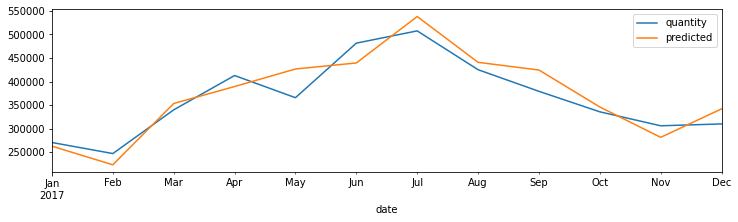

In [311]:
testing_data[['quantity','predicted']].plot(figsize=(12,3))

In [312]:
pred=testing_data['predicted']
actual=testing_data['quantity']

In [313]:
rmse_=rmse_calc(pred,actual)
# Used combination -((0, 0, 1), (1, 1, 1, 12)) RMSE < test RMSE of model without nested-CV (36735.518120690605)

RMSE :  31405.417703415555


## Shop_2 predictions

In [66]:
d2=shop2_data.set_index('date').resample('D').sum()
d2=d2[d2['quantity']>0]
# Considering only non-zero values

In [67]:
# Spliting of data into training and testing sets
training_data2=d2[:60]
testing_data2=d2[60:]

In [68]:
best_p2,best_sp2 = best_parameters(training_data2)

best parameters:  (1, 1, 1)
best seasonal parameters : (1, 1, 1, 12)
minimum aic value 792.7450806061394


In [69]:
model=sm.tsa.statespace.SARIMAX(training_data2,order=best_p2,seasonal_order=best_sp2,enforce_stationarity=False,enforce_invertibility=False)
ts_model=model.fit()

In [70]:
#Forecasting data for next one year
testing_data2['predicted'] = ts_model.forecast(steps=12)

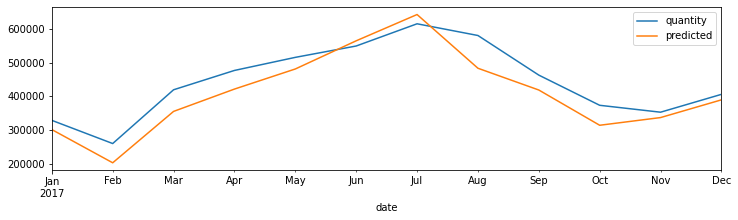

In [71]:
testing_data2[['quantity','predicted']].plot(figsize=(12,3))

In [72]:
pred=testing_data2['predicted']
actual=testing_data2['quantity']
rmse_val=rmse_calc(pred,actual)

RMSE :  48912.3260998625


### Evaluating the Model using Nested Cross Validation

In [77]:
training_data2=d2[:60]
testing_data2=d2[60:]

In [78]:
train_data2=training_data2['quantity']
k2 = len(train_data2)-1

In [80]:
RMSE_history2,Best_Params2=nested_cv(train_data2,k2)

NO OF ITERATION: 1
best parameters:  (0, 0, 0)
best seasonal parameters : (0, 0, 0, 12)
minimum aic value 2.0
RMSE :  267747.0
NO OF ITERATION: 2
best parameters:  (1, 0, 0)
best seasonal parameters : (0, 0, 0, 12)
minimum aic value -17.187973863531113
RMSE :  186719.77103683268
NO OF ITERATION: 3
best parameters:  (1, 1, 0)
best seasonal parameters : (0, 0, 0, 12)
minimum aic value -17.186357967393512
RMSE :  428701.6682839629
NO OF ITERATION: 4
best parameters:  (0, 0, 0)
best seasonal parameters : (0, 1, 0, 12)
minimum aic value 2.0
RMSE :  597746.0
NO OF ITERATION: 5
best parameters:  (0, 0, 0)
best seasonal parameters : (0, 1, 0, 12)
minimum aic value 2.0
RMSE :  681016.0
NO OF ITERATION: 6
best parameters:  (0, 0, 0)
best seasonal parameters : (0, 1, 0, 12)
minimum aic value 2.0
RMSE :  665472.0
NO OF ITERATION: 7
best parameters:  (0, 0, 0)
best seasonal parameters : (0, 1, 0, 12)
minimum aic value 2.0
RMSE :  542441.0
NO OF ITERATION: 8
best parameters:  (0, 0, 0)
best seasonal

In [81]:
# Mean RMSE of Nested Cross Validation
final_mean2=sum(RMSE_history2.values())/k2   
print("mean RMSE value :",final_mean2) 

mean RMSE value : 129901.8618043866


In [82]:
results2=pd.DataFrame()
results2['parameters']=Best_Params2.values()
results2['RMSE']=RMSE_history2.values()

In [83]:
results2.groupby(['parameters'])['RMSE'].mean().sort_values()

parameters
((0, 1, 0), (1, 0, 0, 12))      1666.249758
((0, 0, 1), (1, 1, 1, 12))      3245.166887
((0, 0, 0), (1, 0, 0, 12))      6447.365148
((1, 1, 1), (1, 1, 1, 12))     15144.517675
((0, 1, 0), (0, 1, 0, 12))     39944.000000
((1, 1, 0), (1, 1, 0, 12))     49334.409359
((0, 1, 1), (0, 1, 0, 12))     52501.667620
((1, 1, 1), (1, 1, 0, 12))     74124.557379
((0, 0, 0), (1, 1, 0, 12))     84831.970443
((1, 0, 0), (0, 0, 0, 12))    186719.771037
((1, 1, 0), (0, 1, 0, 12))    208413.447499
((0, 0, 0), (0, 0, 0, 12))    267747.000000
((1, 1, 0), (0, 0, 0, 12))    428701.668284
((0, 0, 0), (0, 1, 0, 12))    469994.555556
Name: RMSE, dtype: float64

In [321]:
results2.groupby(['parameters']).count().sort_values('RMSE',ascending=False)

,RMSE
parameters,
"((1, 1, 0), (1, 1, 0, 12))",21
"((0, 0, 0), (0, 1, 0, 12))",9
"((0, 1, 1), (0, 1, 0, 12))",7
"((1, 1, 1), (1, 1, 0, 12))",7
"((1, 1, 1), (1, 1, 1, 12))",5
"((1, 1, 0), (0, 1, 0, 12))",2
"((0, 0, 0), (0, 0, 0, 12))",1
"((0, 0, 0), (1, 0, 0, 12))",1
"((0, 0, 0), (1, 1, 0, 12))",1


In [ ]:
# Tested with the below combinations
# 1. count=21 - ((1, 1, 0), (1, 1, 0, 12))	
# 2. count=9 - ((0, 0, 0), (0, 1, 0, 12))	
# 3. count=7 - ((0, 1, 1), (0, 1, 0, 12))	

In [198]:
# create the model using the best parameters 
best_p_2=(0, 0, 0)
best_sp_2=(0, 1, 0, 12)
model2=sm.tsa.statespace.SARIMAX(train_data2,order=best_p_2,seasonal_order=best_sp_2,enforce_stationarity=False,enforce_invertibility=False)
ts_model2=model2.fit()

In [199]:
testing_data2['predicted'] = ts_model2.forecast(steps=12)
#test_data

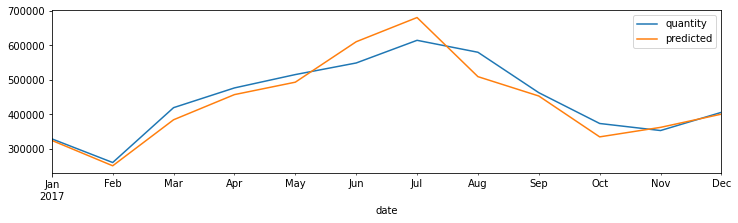

In [200]:
testing_data2[['quantity','predicted']].plot(figsize=(12,3))

In [201]:
pred2=testing_data2['predicted']
actual2=testing_data2['quantity']
rmse_2=rmse_calc(pred2,actual2)
# Used combination -(((0, 0, 0), (0, 1, 0, 12))- RMSE < test RMSE of model without nested-CV (48912.3260998625)

RMSE :  37764.21937385528


## Shop_3 Predictions


In [89]:
d3=shop3_data.set_index('date').resample('D').sum()
d3=d3[d3['quantity']>0]
# Considering only non-zero values

In [90]:
# Spliting of data into training and testing sets
training_data3=d3[:60]
testing_data3=d3[60:]

In [91]:
best_p3,best_sp3 = best_parameters(training_data3)

best parameters:  (1, 1, 1)
best seasonal parameters : (1, 1, 0, 12)
minimum aic value 832.151253554319


In [92]:
model3=sm.tsa.statespace.SARIMAX(training_data3,order=best_p3,seasonal_order=best_sp3,enforce_stationarity=False,enforce_invertibility=False)
ts_model3=model3.fit()

In [93]:
#Forecasting data for next one year
testing_data3['predicted'] = ts_model3.forecast(steps=12)

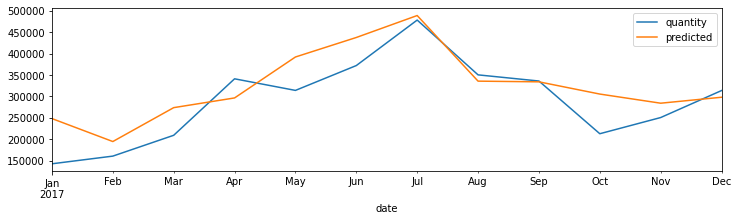

In [94]:
testing_data3[['quantity','predicted']].plot(figsize=(12,3))

In [95]:
pred3=testing_data3['predicted']
actual3=testing_data3['quantity']
rmse_val3=rmse_calc(pred3,actual3)

RMSE :  56983.4452160548


### Evaluation Using Nested CV 

In [96]:
training_data3=d3[:60]
testing_data3=d3[60:]

In [97]:
train_data3=training_data3['quantity']
k3 = len(train_data3)-1

In [98]:
RMSE_history3,Best_Params3=nested_cv(train_data3,k3)

NO OF ITERATION: 1
best parameters:  (0, 0, 0)
best seasonal parameters : (0, 0, 0, 12)
minimum aic value 2.0
RMSE :  175433.0
NO OF ITERATION: 2
best parameters:  (1, 0, 0)
best seasonal parameters : (0, 0, 0, 12)
minimum aic value -17.187973863531113
RMSE :  158084.91552534193
NO OF ITERATION: 3
best parameters:  (1, 1, 0)
best seasonal parameters : (0, 0, 0, 12)
minimum aic value -17.187973863531113
RMSE :  496038.3997091365
NO OF ITERATION: 4
best parameters:  (0, 0, 0)
best seasonal parameters : (0, 1, 0, 12)
minimum aic value 2.0
RMSE :  395835.0
NO OF ITERATION: 5
best parameters:  (0, 0, 0)
best seasonal parameters : (0, 1, 0, 12)
minimum aic value 2.0
RMSE :  424396.0
NO OF ITERATION: 6
best parameters:  (0, 0, 0)
best seasonal parameters : (0, 1, 0, 12)
minimum aic value 2.0
RMSE :  483458.0
NO OF ITERATION: 7
best parameters:  (0, 0, 0)
best seasonal parameters : (0, 1, 0, 12)
minimum aic value 2.0
RMSE :  373624.0
NO OF ITERATION: 8
best parameters:  (0, 0, 0)
best seasonal

In [99]:
# Mean RMSE of Nested Cross Validation
final_mean3=sum(RMSE_history3.values())/k3    
print("mean RMSE value :",final_mean3) 

mean RMSE value : 92124.83062905284


In [100]:
results3=pd.DataFrame()
results3['parameters']=Best_Params3.values()
results3['RMSE']=RMSE_history3.values()

In [101]:
results3.groupby(['parameters'])['RMSE'].mean().sort_values()

parameters
((1, 0, 0), (0, 1, 0, 12))     16000.957895
((0, 0, 0), (1, 0, 0, 12))     17650.344849
((0, 0, 0), (1, 1, 0, 12))     20202.553274
((0, 1, 1), (0, 1, 0, 12))     23023.499995
((1, 1, 1), (0, 1, 0, 12))     30863.307534
((0, 0, 1), (1, 1, 1, 12))     36637.163366
((1, 1, 1), (1, 1, 0, 12))     37199.735213
((0, 1, 1), (1, 1, 1, 12))     45839.023035
((0, 1, 0), (0, 1, 0, 12))     52566.666667
((1, 1, 0), (1, 1, 0, 12))     73525.052435
((1, 0, 0), (0, 0, 0, 12))    158084.915525
((0, 0, 0), (0, 0, 0, 12))    175433.000000
((0, 0, 0), (0, 1, 0, 12))    313054.333333
((1, 1, 0), (0, 0, 0, 12))    496038.399709
Name: RMSE, dtype: float64

In [323]:
results3.groupby(['parameters']).count().sort_values('RMSE',ascending=False)
# ignore hyperparameter corresponding to count=26  

,RMSE
parameters,
"((1, 1, 1), (1, 1, 0, 12))",26
"((0, 0, 0), (0, 1, 0, 12))",9
"((0, 1, 1), (0, 1, 0, 12))",6
"((0, 1, 1), (1, 1, 1, 12))",4
"((0, 1, 0), (0, 1, 0, 12))",3
"((1, 1, 0), (1, 1, 0, 12))",3
"((0, 0, 0), (0, 0, 0, 12))",1
"((0, 0, 0), (1, 0, 0, 12))",1
"((0, 0, 0), (1, 1, 0, 12))",1


In [ ]:
# Tested with the below combinations
# 1. count=9 - ((0, 0, 0), (0, 1, 0, 12))		
# 2. count=6 - ((0, 1, 1), (0, 1, 0, 12))	
# 3. count=4 - ((0, 1, 1), (1, 1, 1, 12))

In [190]:
# create the model using the best parameters 
best_p_3=(0, 0, 0)
best_sp_3=(0, 1, 0, 12)
model3=sm.tsa.statespace.SARIMAX(train_data3,order=best_p_3,seasonal_order=best_sp_3,enforce_stationarity=False,enforce_invertibility=False)
ts_model3=model3.fit()

In [191]:
testing_data3['predicted'] = ts_model3.forecast(steps=12)
#test_data

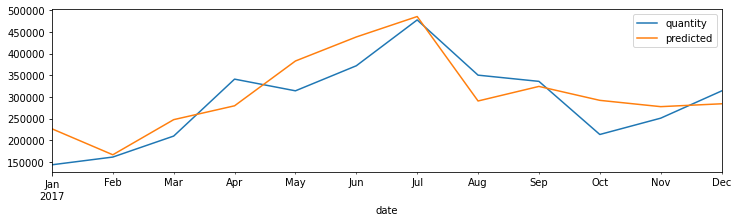

In [192]:
testing_data3[['quantity','predicted']].plot(figsize=(12,3))

In [193]:
pred3=testing_data3['predicted']
actual3=testing_data3['quantity']
rmse_3=rmse_calc(pred3,actual3)
# Used combination -(((0, 0, 0), (0, 1, 0, 12))- RMSE < test RMSE of model without nested-CV (56983.4452160548)

RMSE :  52409.05664815958


## Shop_4 Predictions

In [107]:
d4=shop4_data.set_index('date').resample('D').sum()
d4=d4[d4['quantity']>0]
# Considering only non-zero values

In [108]:
# Spliting of data into training and testing sets
training_data4=d4[:60]
testing_data4=d4[60:]

In [109]:
best_p4,best_sp4 = best_parameters(training_data4)

best parameters:  (1, 1, 1)
best seasonal parameters : (1, 1, 0, 12)
minimum aic value 841.779009708307


In [110]:
model4=sm.tsa.statespace.SARIMAX(training_data2,order=best_p2,seasonal_order=best_sp2,enforce_stationarity=False,enforce_invertibility=False)
ts_model4=model4.fit()

In [111]:
#Forecasting data for next one year
testing_data4['predicted'] = ts_model4.forecast(steps=12)

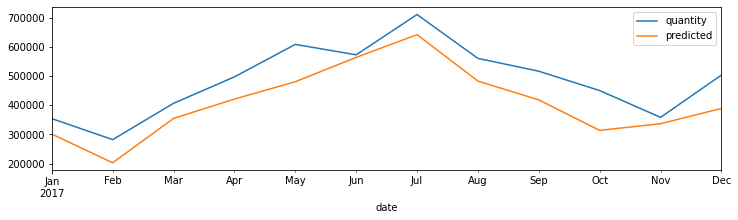

In [112]:
testing_data4[['quantity','predicted']].plot(figsize=(12,3))

In [113]:
pred4=testing_data4['predicted']
actual4=testing_data4['quantity']
rmse_val4=rmse_calc(pred4,actual4)

RMSE :  84977.50223529458


### Evaluation Using Nested CV

In [114]:
training_data4=d4[:60]
testing_data4=d4[60:]

In [115]:
train_data4=training_data4['quantity']
k4 = len(train_data4)-1

In [116]:
RMSE_history4,Best_Params4=nested_cv(train_data4,k4)

NO OF ITERATION: 1
best parameters:  (0, 0, 0)
best seasonal parameters : (0, 0, 0, 12)
minimum aic value 2.0
RMSE :  284018.0
NO OF ITERATION: 2
best parameters:  (1, 0, 0)
best seasonal parameters : (0, 0, 0, 12)
minimum aic value -17.187973863531113
RMSE :  242503.05966967408
NO OF ITERATION: 3
best parameters:  (1, 1, 0)
best seasonal parameters : (0, 0, 0, 12)
minimum aic value -17.187973863531113
RMSE :  470146.47457606875
NO OF ITERATION: 4
best parameters:  (0, 0, 0)
best seasonal parameters : (0, 1, 0, 12)
minimum aic value 2.0
RMSE :  585084.0
NO OF ITERATION: 5
best parameters:  (0, 0, 0)
best seasonal parameters : (0, 1, 0, 12)
minimum aic value 2.0
RMSE :  587595.0
NO OF ITERATION: 6
best parameters:  (0, 0, 0)
best seasonal parameters : (0, 1, 0, 12)
minimum aic value 2.0
RMSE :  736860.0
NO OF ITERATION: 7
best parameters:  (0, 0, 0)
best seasonal parameters : (0, 1, 0, 12)
minimum aic value 2.0
RMSE :  630978.0
NO OF ITERATION: 8
best parameters:  (0, 0, 0)
best seasona

In [117]:
# Mean RMSE of Nested Cross Validation
final_mean4=sum(RMSE_history4.values())/k4    
print("mean RMSE value :",final_mean4) 

mean RMSE value : 134716.31209235068


In [118]:
results4=pd.DataFrame()
results4['parameters']=Best_Params4.values()
results4['RMSE']=RMSE_history4.values()

In [119]:
results4.groupby(['parameters'])['RMSE'].mean().sort_values()
#This shows average error is less for parameters - ((0, 0, 0), (1, 1, 0, 12))

parameters
((0, 1, 0), (1, 0, 0, 12))      8837.392548
((0, 0, 0), (1, 0, 0, 12))      9553.173924
((0, 0, 0), (1, 1, 0, 12))     21186.715189
((1, 1, 1), (0, 1, 0, 12))     27495.013375
((0, 1, 1), (1, 1, 1, 12))     30955.169904
((1, 1, 1), (1, 1, 0, 12))     32845.705984
((1, 0, 1), (1, 1, 1, 12))     53000.060273
((1, 1, 0), (1, 1, 0, 12))     62983.375098
((0, 1, 1), (0, 1, 0, 12))     66976.164300
((0, 1, 0), (0, 1, 0, 12))     87756.000000
((1, 1, 1), (1, 1, 1, 12))    105555.213623
((1, 1, 0), (0, 1, 0, 12))    153312.571281
((1, 0, 0), (0, 0, 0, 12))    242503.059670
((0, 0, 0), (0, 0, 0, 12))    284018.000000
((1, 1, 0), (0, 0, 0, 12))    470146.474576
((0, 0, 0), (0, 1, 0, 12))    479408.444444
Name: RMSE, dtype: float64

In [324]:
results4.groupby(['parameters']).count().sort_values('RMSE',ascending=False)

,RMSE
parameters,
"((1, 1, 0), (1, 1, 0, 12))",19
"((0, 0, 0), (0, 1, 0, 12))",9
"((1, 1, 1), (1, 1, 0, 12))",6
"((0, 1, 1), (0, 1, 0, 12))",5
"((0, 1, 1), (1, 1, 1, 12))",5
"((1, 0, 1), (1, 1, 1, 12))",3
"((1, 1, 0), (0, 1, 0, 12))",2
"((1, 1, 1), (0, 1, 0, 12))",2
"((0, 0, 0), (0, 0, 0, 12))",1


In [ ]:
# Tested with the below combinations
# 1. count=19 - ((1, 1, 0), (1, 1, 0, 12))		
# 2. count=9  - ((0, 0, 0), (0, 1, 0, 12))	
# 3. count=6 -  ((1, 1, 1), (1, 1, 0, 12))

In [125]:
# create the model using the best parameters 
best_p_4=(0,0,0)
best_sp_4=(0, 1, 0, 12)
model4=sm.tsa.statespace.SARIMAX(train_data4,order=best_p_4,seasonal_order=best_sp_4,enforce_stationarity=False,enforce_invertibility=False)
ts_model4=model4.fit()

In [126]:
testing_data4['predicted'] = ts_model4.forecast(steps=12)
#test_data4

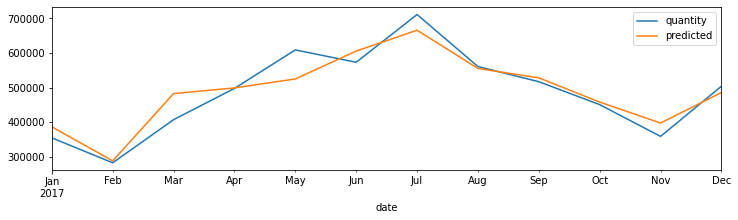

In [127]:
testing_data4[['quantity','predicted']].plot(figsize=(12,3))

In [128]:
pred4=testing_data4['predicted']
actual4=testing_data4['quantity']
rmse_4=rmse_calc(pred4,actual4)
# used combination -((0, 0, 0), (0, 1, 0, 12))- RMSE < test RMSE of model without nested-CV (84977.50223529458)

RMSE :  39763.122159022336


## Shop_5 Predictions

In [129]:
d5=shop5_data.set_index('date').resample('D').sum()
d5=d5[d5['quantity']>0]
# Considering only non-zero values

In [130]:
# Spliting of data into training and testing sets
training_data5=d5[:60]
testing_data5=d5[60:]

In [131]:
best_p5,best_sp5 = best_parameters(training_data5)

best parameters:  (1, 1, 1)
best seasonal parameters : (1, 1, 0, 12)
minimum aic value 832.4195570399913


In [132]:
model5=sm.tsa.statespace.SARIMAX(training_data5,order=best_p5,seasonal_order=best_sp5,enforce_stationarity=False,enforce_invertibility=False)
ts_model5=model5.fit()

In [133]:
#Forecasting data for next one year
testing_data5['predicted'] = ts_model5.forecast(steps=12)

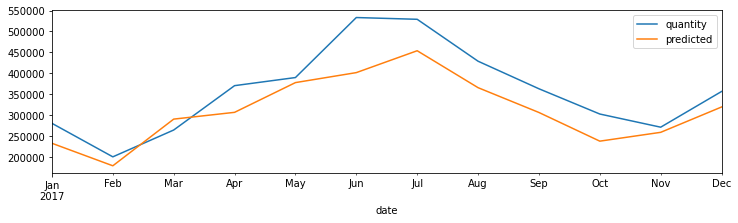

In [135]:
testing_data5[['quantity','predicted']].plot(figsize=(12,3))

In [136]:
pred5=testing_data5['predicted']
actual5=testing_data5['quantity']
rmse_val5=rmse_calc(pred5,actual5)

RMSE :  60191.87639274419


### Evaluation Using Nested CV

In [137]:
training_data5=d5[:60]
testing_data5=d5[60:]

In [138]:
train_data5=training_data5['quantity']
k5 = len(train_data5)-1

In [139]:
RMSE_history5,Best_Params5=nested_cv(train_data5,k5)

NO OF ITERATION: 1
best parameters:  (0, 0, 0)
best seasonal parameters : (0, 0, 0, 12)
minimum aic value 2.0
RMSE :  184943.0
NO OF ITERATION: 2
best parameters:  (1, 0, 0)
best seasonal parameters : (0, 0, 0, 12)
minimum aic value -17.187973863531113
RMSE :  181310.9748049344
NO OF ITERATION: 3
best parameters:  (1, 1, 0)
best seasonal parameters : (0, 0, 0, 12)
minimum aic value -17.187973863531113
RMSE :  300285.3656687634
NO OF ITERATION: 4
best parameters:  (0, 0, 0)
best seasonal parameters : (0, 1, 0, 12)
minimum aic value 2.0
RMSE :  414544.0
NO OF ITERATION: 5
best parameters:  (0, 0, 0)
best seasonal parameters : (0, 1, 0, 12)
minimum aic value 2.0
RMSE :  447367.0
NO OF ITERATION: 6
best parameters:  (0, 0, 0)
best seasonal parameters : (0, 1, 0, 12)
minimum aic value 2.0
RMSE :  477688.0
NO OF ITERATION: 7
best parameters:  (0, 0, 0)
best seasonal parameters : (0, 1, 0, 12)
minimum aic value 2.0
RMSE :  457451.0
NO OF ITERATION: 8
best parameters:  (0, 0, 0)
best seasonal 

In [140]:
# Mean RMSE of Nested Cross Validation
final_mean5=sum(RMSE_history5.values())/k5    
print("mean RMSE value :",final_mean5) 

mean RMSE value : 104570.06131791987


In [141]:
results5=pd.DataFrame()
results5['parameters']=Best_Params5.values()
results5['RMSE']=RMSE_history5.values()

In [143]:
results5.groupby(['parameters'])['RMSE'].mean().sort_values()

parameters
((0, 0, 0), (1, 1, 0, 12))      6771.526514
((0, 1, 1), (1, 1, 1, 12))     18692.815086
((0, 1, 0), (0, 1, 0, 12))     26043.000000
((0, 0, 1), (1, 1, 1, 12))     33242.856839
((0, 0, 0), (1, 0, 0, 12))     41054.431324
((0, 1, 1), (0, 1, 0, 12))     48196.970484
((1, 1, 1), (1, 1, 0, 12))     50132.973446
((1, 1, 0), (1, 1, 0, 12))     52227.351271
((1, 1, 0), (0, 1, 0, 12))     60485.990573
((1, 1, 1), (0, 1, 0, 12))     65918.701763
((0, 1, 0), (1, 0, 0, 12))     70022.027371
((1, 0, 0), (0, 0, 0, 12))    181310.974805
((0, 0, 0), (0, 0, 0, 12))    184943.000000
((1, 1, 0), (0, 0, 0, 12))    300285.365669
((0, 0, 0), (0, 1, 0, 12))    354288.333333
Name: RMSE, dtype: float64

In [326]:
results5.groupby(['parameters']).count().sort_values('RMSE',ascending=False)

,RMSE
parameters,
"((1, 1, 0), (1, 1, 0, 12))",16
"((1, 1, 1), (1, 1, 0, 12))",14
"((0, 0, 0), (0, 1, 0, 12))",9
"((1, 1, 1), (0, 1, 0, 12))",4
"((0, 1, 1), (0, 1, 0, 12))",3
"((0, 0, 1), (1, 1, 1, 12))",2
"((0, 1, 1), (1, 1, 1, 12))",2
"((1, 1, 0), (0, 1, 0, 12))",2
"((0, 0, 0), (0, 0, 0, 12))",1


In [ ]:
# Tested with the below combinations
# 1. count=16 - ((1, 1, 0), (1, 1, 0, 12))		
# 2. count=14 - ((1, 1, 1), (1, 1, 0, 12))	
# 3. count=9  - ((0, 0, 0), (0, 1, 0, 12))

In [149]:
# create the model using the best parameters 
best_p_5=(0,0,0)
best_sp_5=(0, 1, 0, 12)
model5=sm.tsa.statespace.SARIMAX(train_data5,order=best_p_5,seasonal_order=best_sp_5,enforce_stationarity=False,enforce_invertibility=False)
ts_model5=model5.fit()

In [150]:
testing_data5['predicted'] = ts_model5.forecast(steps=12)
#test_data

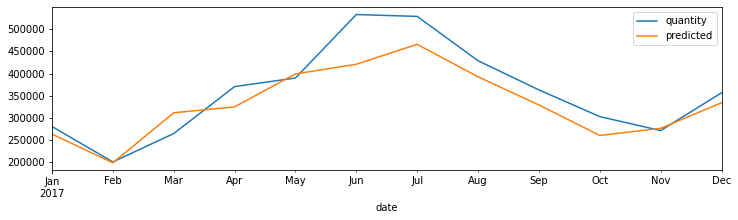

In [151]:
testing_data5[['quantity','predicted']].plot(figsize=(12,3))

In [152]:
pred5=testing_data5['predicted']
actual5=testing_data5['quantity']
rmse_5=rmse_calc(pred5,actual5)
# Used combination -((0, 0, 0), (0, 1, 0, 12))- RMSE < test RMSE of model without nested-CV (60191.87639274419)

RMSE :  46590.179317462746


## Shop_6 Predictions

In [153]:
d6=shop6_data.set_index('date').resample('D').sum()
d6=d6[d6['quantity']>0]
# Considering only non-zero values

In [154]:
# Spliting of data into training and testing sets
training_data6=d6[:60]
testing_data6=d6[60:]

In [155]:
best_p6,best_sp6 = best_parameters(training_data6)

best parameters:  (1, 1, 1)
best seasonal parameters : (1, 1, 0, 12)
minimum aic value 861.7572380026071


In [156]:
model6=sm.tsa.statespace.SARIMAX(training_data6,order=best_p6,seasonal_order=best_sp6,enforce_stationarity=False,enforce_invertibility=False)
ts_model6=model6.fit()

In [157]:
#Forecasting data for next one year
testing_data6['predicted'] = ts_model6.forecast(steps=12)

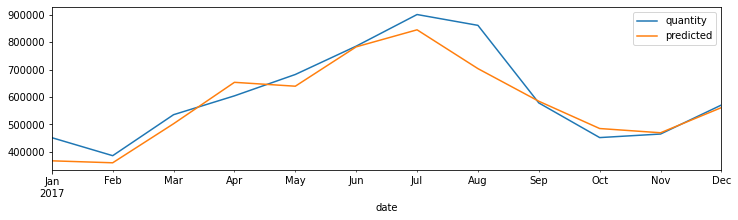

In [158]:
testing_data6[['quantity','predicted']].plot(figsize=(12,3))

In [159]:
pred6=testing_data6['predicted']
actual6=testing_data6['quantity']
rmse_val6=rmse_calc(pred6,actual6)

RMSE :  59354.158972780424


### Evaluation Using Nested CV

In [160]:
training_data6=d6[:60]
testing_data6=d6[60:]

In [161]:
train_data6=training_data6['quantity']
k6 = len(train_data6)-1

In [162]:
RMSE_history6,Best_Params6=nested_cv(train_data6,k6)

NO OF ITERATION: 1
best parameters:  (0, 0, 0)
best seasonal parameters : (0, 0, 0, 12)
minimum aic value 2.0
RMSE :  425045.0
NO OF ITERATION: 2
best parameters:  (1, 0, 0)
best seasonal parameters : (0, 0, 0, 12)
minimum aic value -17.18797386349723
RMSE :  69480.67173557496
NO OF ITERATION: 3
best parameters:  (1, 1, 0)
best seasonal parameters : (0, 0, 0, 12)
minimum aic value -17.187973863531113
RMSE :  246128.2170443858
NO OF ITERATION: 4
best parameters:  (0, 0, 0)
best seasonal parameters : (0, 1, 0, 12)
minimum aic value 2.0
RMSE :  755197.0
NO OF ITERATION: 5
best parameters:  (0, 0, 0)
best seasonal parameters : (0, 1, 0, 12)
minimum aic value 2.0
RMSE :  897477.0
NO OF ITERATION: 6
best parameters:  (0, 0, 0)
best seasonal parameters : (0, 1, 0, 12)
minimum aic value 2.0
RMSE :  913833.0
NO OF ITERATION: 7
best parameters:  (0, 0, 0)
best seasonal parameters : (0, 1, 0, 12)
minimum aic value 2.0
RMSE :  808380.0
NO OF ITERATION: 8
best parameters:  (0, 0, 0)
best seasonal p

In [163]:
# Mean RMSE of Nested Cross Validation
final_mean6=sum(RMSE_history6.values())/k6    
print("mean RMSE value :",final_mean6) 

mean RMSE value : 185686.2217172387


In [164]:
results6=pd.DataFrame()
results6['parameters']=Best_Params6.values()
results6['RMSE']=RMSE_history6.values()

In [165]:
results6.groupby(['parameters'])['RMSE'].mean().sort_values()
#This shows average error is less for parameters - ((0, 0, 0), (1, 1, 0, 12))

parameters
((0, 0, 0), (1, 0, 0, 12))      8863.945061
((0, 0, 1), (1, 1, 1, 12))      9556.592077
((0, 0, 0), (1, 1, 0, 12))     26058.408579
((1, 1, 1), (0, 1, 0, 12))     51771.966985
((1, 1, 1), (1, 1, 0, 12))     52567.913673
((1, 1, 0), (0, 1, 0, 12))     58462.394753
((1, 0, 0), (0, 0, 0, 12))     69480.671736
((0, 1, 1), (1, 1, 1, 12))     71758.922865
((0, 1, 0), (1, 0, 0, 12))    127005.722703
((1, 1, 0), (1, 1, 0, 12))    185948.804485
((0, 0, 1), (0, 1, 0, 12))    199865.495820
((0, 1, 1), (0, 1, 0, 12))    201311.306041
((1, 1, 0), (0, 0, 0, 12))    246128.217044
((0, 0, 0), (0, 0, 0, 12))    425045.000000
((0, 0, 0), (0, 1, 0, 12))    639281.444444
((1, 1, 0), (1, 0, 0, 12))    644024.772067
Name: RMSE, dtype: float64

In [328]:
results6.groupby(['parameters']).count().sort_values('RMSE',ascending=False)

,RMSE
parameters,
"((1, 1, 1), (1, 1, 0, 12))",23
"((0, 0, 0), (0, 1, 0, 12))",9
"((1, 1, 0), (1, 1, 0, 12))",7
"((1, 1, 1), (0, 1, 0, 12))",5
"((0, 1, 1), (1, 1, 1, 12))",3
"((0, 1, 1), (0, 1, 0, 12))",2
"((0, 0, 0), (0, 0, 0, 12))",1
"((0, 0, 0), (1, 0, 0, 12))",1
"((0, 0, 0), (1, 1, 0, 12))",1


In [327]:
# Tested with the below combinations
# 1. count=23 - ((1, 1, 1), (1, 1, 0, 12))		
# 2. count=9  - ((0, 0, 0), (0, 1, 0, 12))	
# 3. count=7  - ((1, 1, 0), (1, 1, 0, 12))

In [178]:
# create the model using the best parameters 
best_p_6=(0, 0, 0)
best_sp_6=(0, 1, 0, 12)
model6=sm.tsa.statespace.SARIMAX(train_data6,order=best_p_6,seasonal_order=best_sp_6,enforce_stationarity=False,enforce_invertibility=False)
ts_model6=model6.fit()

In [179]:
testing_data6['predicted'] = ts_model6.forecast(steps=12)
#test_data

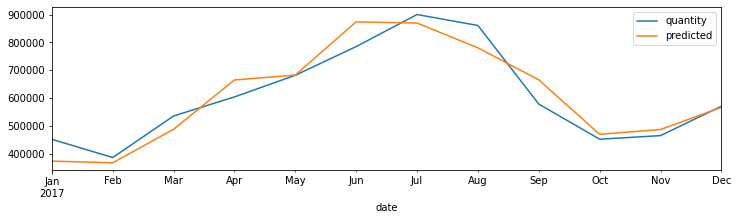

In [180]:
testing_data6[['quantity','predicted']].plot(figsize=(12,3))

In [181]:
pred6=testing_data6['predicted']
actual6=testing_data6['quantity']
rmse_6=rmse_calc(pred6,actual6)
# used combination -((0, 0, 0), (0, 1, 0, 12))- RMSE < test RMSE of model without nested-CV ( 59354.158972780424)

RMSE :  54885.4488951003


## Observations

###### 1. The best hyperparameter combination chosen by using complete training data was not performing well for the test data. This might be due to hyperparameter overfitting.

###### 2. Nested CV is very useful to identify a possible set of best hyperparameter combinations that can give better prediction accuracy. 
###### 3. Mean RMSE of Nested CV results are observed as high values compared to test RMSE errors. Small size of training data sets could be a reason. 
######         RMSE Values :
###### shop_1 = 107682.98832792624
###### shop_2 = 129901.8618043866
###### shop_3 = 92124.83062905284
###### shop_4 = 134716.31209235068 
###### shop_5 = 104570.06131791987
###### shop_6 = 185686.2217172387
            